In [1]:
# Custom libraries
from libraries.dataPreprocessing import *
from libraries.snnNetwork import *
from libraries.datasetLoader import *

# Pytorch imports
from torch.utils.data import DataLoader

# Matplotlib imports
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Parse .csv files
import pandas as pd

# Script options
import getopt
import sys

In [2]:
# File paths
sourceFile = './datasets/iris/iris.data'
saveFile = './processedData/iris.data'
networkFile = './networks/irisNetwork.pt'

In [3]:
# Data characteristics
variablePositions = [0, 1, 2, 3]
resultPosition = 4
resultEncoding = {
  "Iris-setosa": "0",
  "Iris-versicolor": "1",
  "Iris-virginica": "2"
}


# Iris Dataset information

SOURCE: https://archive.ics.uci.edu/dataset/53/iris 

FROM: iris.names

1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 
      -- Iris Setosa
      -- Iris Versicolour
      -- Iris Virginica
4. Missing Attribute Values: None

Summary Statistics:
|                   | Min | Max | Mean | SD   | Class Correlation |
|-------------------|-----|-----|------|------|-------------------|
| sepal length:     | 4.3 | 7.9 | 5.84 | 0.83 | 0.7826            |
| sepal width:      | 2.0 | 4.4 | 3.05 | 0.43 | -0.4194           |
| petal length:     | 1.0 | 6.9 | 3.76 | 1.76 | 0.9490   (high!)  |
| petal width:      | 0.1 | 2.5 | 1.20 | 0.76 | 0.9565   (high!)  |

5. Class Distribution: 33.3% for each of 3 classes.

## 2. Processing Data

In [4]:
# Read data
elementSeparator = '\n'
parameterSeparator = ','

In [5]:
print("Reading data: ", sourceFile)
rawData = readCSVData(sourceFile, elementSeparator, parameterSeparator)

Reading data:  ./datasets/iris/iris.data


In [6]:
# Process data
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10

In [7]:
print(len(rawData[0]), ",", len(rawData))
print(type(rawData))
rawData[:2]

5 , 150
<class 'list'>


[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa']]

In [8]:
# Example with no result interval calculation (directly write excitation)
processedData = processData(data=rawData, 
                            variablePositions=variablePositions, 
                            nInputNeurons=nInputNeurons, 
                            fieldSuperposition=fieldSuperposition,
                            add_results=True,
                            resultEncoding=resultEncoding,
                            resultPosition=resultPosition,
                            gaussian=False,
                            normalize=True,
                            )

In [9]:
print(len(processedData[0]), ",", len(processedData))
print(type(processedData))
processedData[:2]

5 , 150
<class 'list'>


[[0.22222222222222213,
  0.6249999999999999,
  0.06779661016949151,
  0.04166666666666667,
  '0'],
 [0.1666666666666668,
  0.41666666666666663,
  0.06779661016949151,
  0.04166666666666667,
  '0']]

In [10]:
# Save data
elementSeparator = '\n'
parameterSeparator = ','
writeCSVData(processedData, saveFile, elementSeparator, parameterSeparator, rearrange=True)

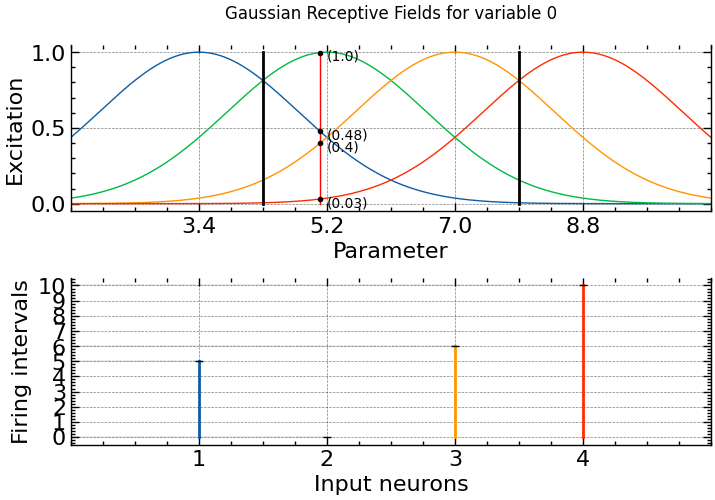

In [11]:
#How to plot a random data point (if Gaussian encoding is used)

figurePath = './figures/irisPlot.pdf'
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10
elementToPlot = 0
parameterToPlot = 0

plotDataPoint(rawData, figurePath, fieldSuperposition, nInputNeurons, \
              nIntervals, elementToPlot, parameterToPlot)


# 3. Train and test LIF Network

In [12]:
# Network Architecture
num_inputs = len(variablePositions)
num_hidden = 16
num_outputs = len(resultEncoding)
num_steps = 30

In [13]:
# Definitions to load the network to cuda
batch_size = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [14]:
# Initialize datasets for training and testing
irisDataset_train =  CustomDataset(data_path=saveFile, train=True)
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [15]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_train = DataLoader(irisDataset_train, batch_size=batch_size, drop_last=True)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)

In [16]:
net = NetLIF(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [17]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [18]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


Train set loss: 27.140705108642578
Train set loss: 19.980836868286133


In [19]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 43/45
Test accuracy: 95.56%


In [20]:
# Save the model
torch.save(net.state_dict(), networkFile)

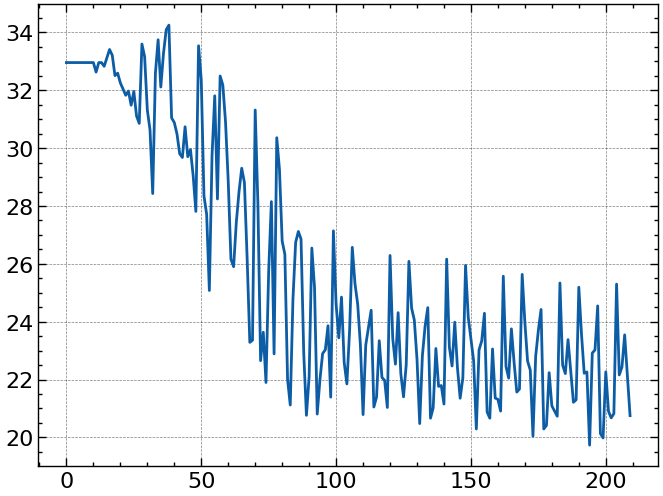

In [21]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

# 4. Test Izhikevich Network

In [22]:
# Initialize datasets for training and testing
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [23]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)


In [24]:
# Define new network
num_steps = 30
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

print('Loading network: ', networkFile)
net.load_state_dict(torch.load(networkFile))

total = 0
correct = 0

print('Starting Izhikevich network evaluation')
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with Izhi network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Loading network:  ./networks/irisNetwork.pt
Starting Izhikevich network evaluation
Total correctly classified elements with Izhi network: 29/45
Test accuracy: 64.44%


/tmp/ipykernel_365881/3463770202.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(networkFile))
